In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

/home/liyuante/miniconda3/envs/py388/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 对给定的路径的图片进行加载和显示
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

# 定义归一化的值，用于torchvision中的预训练模型
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

# 将几个图像变换组合在一起。
# 在将图像输入神经网络之前，将使用此预处理。
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalise
    ])

# 函数用于恢复应用于图像张量的归一化。
# 处理预处理后，可以使用此函数以其原始形式显示图像。
def deprocess(image):
    device = image.device  # 获取 image 的设备信息
    return image * torch.Tensor([0.229, 0.224, 0.225]).to(device) + torch.Tensor([0.485, 0.456, 0.406]).to(device)



In [3]:
vgg = models.vgg19(pretrained=True)
vgg = vgg.cuda()
print(vgg)
modulelist = list(vgg.features.modules())

/home/liyuante/miniconda3/envs/py388/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/liyuante/miniconda3/envs/py388/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
def dd_helper(image, layer, iterations, lr):        
    # 将图像预处理并将其转移到GPU上
    input = preprocess(image).unsqueeze(0).cuda()
    input.requires_grad = True

    # unsqueeze(0)就是在索引0的位置新加一个维度，本来在0的维度向后延
    
    # 清除VGG网络的梯度
    vgg.zero_grad()
    
    # 对图像进行多次迭代，目的是最大化特定层的激活
    for i in range(iterations):
        out = input
        # 遍历VGG网络到指定的层
        for j in range(layer):
            out = modulelist[j + 1](out)  # 执行前向传播
            # 实际上就是将 out 传递给列表中的下一个模块，并接收其输出，然后将输出赋值回 out
        
        # 计算所选层的激活的范数作为损失
        loss = out.norm()
        
        # 反向传播计算梯度
        loss.backward()
        
        # 更新图像数据以最大化激活
        input.data = input.data + lr * input.grad.data
    
    # 调整图像张量的维度以匹配标准图像形状
    input = input.data.squeeze()  # 移除张量中的大小为 1 的维度
    input.transpose_(0, 1)  # 交换第 0 和第 1 维
    input.transpose_(1, 2)  # 交换第 1 和第 2 维
    
    # 反向预处理图像并确保像素值在0到1之间
    input = input.cpu()
    input = np.clip(deprocess(input), 0, 1)
    
    # 将处理后的图像张量转换为PIL图像并返回
    im = Image.fromarray(np.uint8(input * 255))
    return im


`input`的形状原先为 $([1, C, H, W])$（一个批量大小为 1 的图像，其中 $C$ 是通道数，$H$ 是高度，$W$ 是宽度），经过 操作后，`input`的形状变为了标准的图像形状 $([H, W, C])$。

In [5]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    # 如果还有多的octaves需要处理
    if num_octaves > 0:
        # 对图像应用高斯模糊滤波
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        
        # 检查图像缩放后的尺寸是否大于1，否则保持当前尺寸
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
            
        # 将图像缩小
        image1 = image1.resize(size, Image.Resampling.LANCZOS)
        # 递归调用 deep_dream_vgg 处理缩小的图像
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        # 将处理后的图像放大到原始尺寸
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        # 将原始图像和处理后的图像混合，使用 0.6 的混合系数
        image = ImageChops.blend(image, image1, 0.6)
        
    # 调用 dd_helper 函数处理图像，并获取结果
    img_result = dd_helper(image, layer, iterations, lr)
    # 将结果图像调整为原始尺寸
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

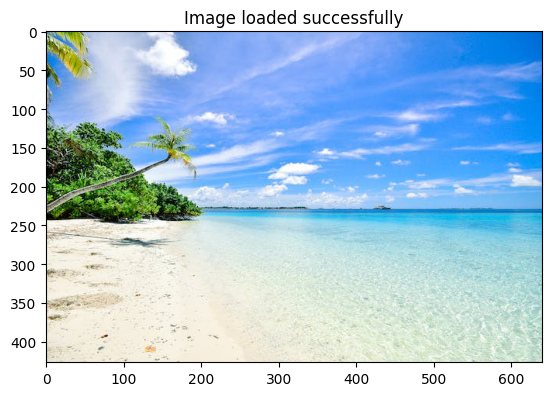

In [6]:
beach = load_image("sea&beach.jpg")

/tmp/ipykernel_4047/3852745379.py:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image1 = image1.resize(size, Image.ANTIALIAS)


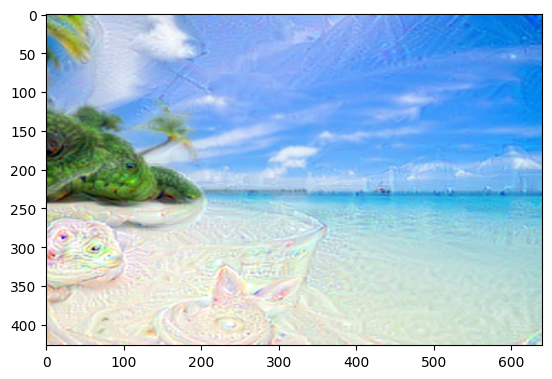

In [7]:
beach_30 = deep_dream_vgg(beach, 30, 8, 0.02, 2, 10)

/tmp/ipykernel_4047/1369363402.py:6: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text)
/tmp/ipykernel_4047/1369363402.py:6: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


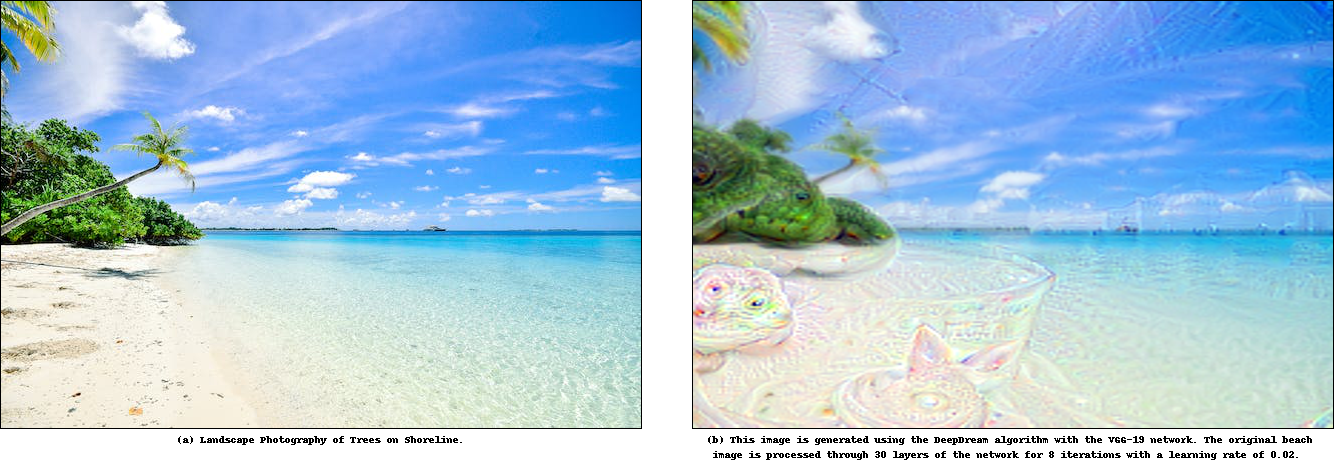

In [9]:
from PIL import ImageDraw, ImageFont

def add_text_below(image, text, font_size=20):
    """在图像下方添加文字描述"""
    draw = ImageDraw.Draw(image)
    text_width, text_height = draw.textsize(text)
    
    # 创建一个新的图像，其高度为原始图像的高度加上文字的高度和一些额外的间距
    new_img = Image.new('RGB', (max(image.width, text_width), image.height + text_height + 10), 'white')
    new_img.paste(image, (0, 0))
    
    # 在新图像的下方中央位置添加文字
    text_position = ((new_img.width - text_width) // 2, image.height + 5)
    new_draw = ImageDraw.Draw(new_img)
    new_draw.text(text_position, text, fill='black')
    
    return new_img

def add_border(image, border_width=1):
    """为图像添加边框"""
    new_img = Image.new('RGB', (image.width + 2*border_width, image.height + 2*border_width), 'black')
    new_img.paste(image, (border_width, border_width))
    return new_img

# 为两张图片添加黑色边框
beach_bordered = add_border(beach)
beach_30_bordered = add_border(beach_30)

# 为每张图片添加文字描述
text_beach = "(a) Landscape Photography of Trees on Shoreline."
text_beach_30 = "(b) This image is generated using the DeepDream algorithm with the VGG-19 network. The original beach \n image is processed through 30 layers of the network for 8 iterations with a learning rate of 0.02."

beach_with_text = add_text_below(beach_bordered, text_beach)
beach_30_with_text = add_text_below(beach_30_bordered, text_beach_30)

# 创建一个新的合成图像
gap = 50  # 两张图片之间的距离
total_width = beach_with_text.width + beach_30_with_text.width + gap
max_height = max(beach_with_text.height, beach_30_with_text.height)

combined_img_with_text = Image.new('RGB', (total_width, max_height), 'white')
combined_img_with_text.paste(beach_with_text, (0, 0))
combined_img_with_text.paste(beach_30_with_text, (beach_with_text.width + gap, 0))

combined_img_with_text.show()  # 显示图像
combined_img_with_text  # 返回图像对象，以便进一步使用或保存
